In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to dataset files:", path)

/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Path to dataset files: /Users/macbookpro/.cache/kagglehub/datasets/snehaanbhawal/resume-dataset/versions/1


# Deliverable 2: Agent & Search Algorithm Implementation

## AI-Powered Resume Screening System

#**Goal:** Implement an intelligent agent that uses A* search algorithm to find the best matching candidates for a job position.

---

## Table of Contents
1. Load Dataset
2. Helper Functions (Resume Parsing)
3. Candidate Class
4. Search Agent with A* Algorithm
5. Demo: Find Top Candidates
6. Performance Analysis

## Step 1: Load the Dataset

In [3]:
# Load the resume dataset
df = pd.read_csv('/Users/macbookpro/.cache/kagglehub/datasets/snehaanbhawal/resume-dataset/versions/1/Resume/Resume.csv')

print(f"📊 Dataset loaded successfully!")
print(f"Total resumes: {len(df)}")
print(f"Job categories: {df['Category'].nunique()}")
print(f"\nFirst few categories: {df['Category'].unique()[:5]}")
print(f"\nDataset shape: {df.shape}")
df.head()

📊 Dataset loaded successfully!
Total resumes: 2484
Job categories: 24

First few categories: ['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE']

Dataset shape: (2484, 4)


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## Step 2: Helper Functions for Resume Parsing

These functions extract important information from resumes:

In [5]:
def extract_skills(resume_text):
    """
    Extract skills from resume text by matching keywords.
    Simple keyword matching approach.
    """
    # Common skills to look for
    skill_keywords = [
        'python', 'java', 'javascript', 'sql', 'c++', 'react', 'nodejs',
        'machine learning', 'deep learning', 'tensorflow', 'pytorch',
        'aws', 'azure', 'docker', 'kubernetes', 'git',
        'html', 'css', 'mongodb', 'postgresql', 'excel',
        'data analysis', 'communication', 'leadership', 'management'
    ]
    
    resume_lower = resume_text.lower()
    found_skills = []
    
    for skill in skill_keywords:
        if skill in resume_lower:
            found_skills.append(skill)
    
    return found_skills


def extract_experience_years(resume_text):
    """
    Extract years of experience from resume using regex patterns.
    Looks for patterns like "5 years", "3+ years", etc.
    """
    patterns = [
        r'(\d+)\+?\s*years?\s+(?:of\s+)?experience',
        r'experience\s+(?:of\s+)?(\d+)\+?\s*years?',
        r'(\d+)\+?\s*yrs?'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, resume_text.lower())
        if match:
            return int(match.group(1))
    
    # If no pattern found, return 0
    return 0


# Test the functions
sample_resume = df['Resume_str'].iloc[0]
print("Sample Resume Skills:", extract_skills(sample_resume))
print("Sample Resume Experience:", extract_experience_years(sample_resume), "years")

Sample Resume Skills: ['aws', 'data analysis', 'leadership', 'management']
Sample Resume Experience: 15 years


## Step 3: Candidate Class

This class represents each candidate with their information:

In [6]:
class Candidate:
    """
    Represents a job candidate with their resume information.
    
    Attributes:
        id: Unique identifier
        name: Candidate name (anonymous in this dataset)
        resume_text: Full resume text
        category: Job category (e.g., "Data Science", "Java Developer")
        skills: List of skills extracted from resume
        experience: Years of experience
    """
    
    def __init__(self, candidate_id, resume_text, category):
        self.id = candidate_id
        self.name = f"Candidate_{candidate_id}"
        self.resume_text = resume_text
        self.category = category
        
        # Extract features from resume
        self.skills = extract_skills(resume_text)
        self.experience = extract_experience_years(resume_text)
    
    def __repr__(self):
        return f"Candidate(id={self.id}, category={self.category}, skills={len(self.skills)}, exp={self.experience})"


# Create candidate objects from dataset (use first 500 for faster demo)
print("Creating candidate objects...")
candidates = []

for idx, row in df.head(500).iterrows():
    candidate = Candidate(
        candidate_id=idx,
        resume_text=row['Resume_str'],
        category=row['Category']
    )
    candidates.append(candidate)

print(f"✅ Created {len(candidates)} candidate objects")
print(f"\nExample candidate: {candidates[0]}")
print(f"Skills: {candidates[0].skills[:5]}...")  # Show first 5 skills

Creating candidate objects...
✅ Created 500 candidate objects

Example candidate: Candidate(id=0, category=HR, skills=4, exp=15)
Skills: ['aws', 'data analysis', 'leadership', 'management']...


## Step 4: Intelligent Search Agent with A* Algorithm

This is a **Goal-Based Agent** that uses **A\* Search Algorithm** to find the best candidates.

### Agent Components:
- **Percepts**: Job requirements (skills, experience)
- **Goal**: Find top K candidates matching the job
- **Actions**: Search, rank, and retrieve candidates
- **Heuristic**: Calculate match score based on skills and experience

In [7]:
import heapq
import time

class SearchAgent:
    """
    Goal-Based Intelligent Agent using A* Search Algorithm.
    
    Agent Type: Goal-based agent
    Goal: Find the best matching candidates for a job position
    
    Performance Measure:
    - Match quality (skill overlap + experience match)
    - Search efficiency (time complexity)
    """
    
    def __init__(self, candidates):
        self.candidates = candidates
        self.goal = "Find top candidates matching job requirements"
        print(f"🤖 Agent initialized with {len(candidates)} candidates")
    
    def heuristic(self, candidate, job_requirements):
        """
        A* Heuristic Function: h(n)
        
        Calculates how well a candidate matches job requirements.
        
        Formula:
        h(n) = w1 * skill_match + w2 * experience_match
        
        Where:
        - skill_match = (matching skills) / (required skills)
        - experience_match = min(1.0, candidate_exp / required_exp)
        - w1 = 0.6 (weight for skills)
        - w2 = 0.4 (weight for experience)
        
        Returns: Score between 0 and 1 (higher is better)
        
        Admissibility: This heuristic never overestimates the true match quality
        because it's based on actual overlaps and ratios ≤ 1.
        """
        required_skills = job_requirements.get('skills', [])
        min_experience = job_requirements.get('min_experience', 1)
        
        # Calculate skill overlap
        if len(required_skills) > 0:
            matching_skills = set(candidate.skills) & set(required_skills)
            skill_match = len(matching_skills) / len(required_skills)
        else:
            skill_match = 0.0
        
        # Calculate experience match
        if min_experience > 0:
            experience_match = min(1.0, candidate.experience / min_experience)
        else:
            experience_match = 1.0
        
        # Weighted combination
        w1, w2 = 0.6, 0.4
        h_score = w1 * skill_match + w2 * experience_match
        
        return h_score
    
    def a_star_search(self, job_requirements, top_k=10):
        """
        A* Search Algorithm to find top K candidates.
        
        Algorithm:
        1. Calculate heuristic score h(n) for each candidate
        2. Use priority queue (min-heap) with -h(n) as priority
        3. Extract top K candidates
        
        Time Complexity: O(N log N) where N = number of candidates
        Space Complexity: O(N) for the priority queue
        
        Args:
            job_requirements: Dict with 'skills' and 'min_experience'
            top_k: Number of top candidates to return
        
        Returns:
            List of top K candidates with their scores
        """
        print(f"\n🔍 Starting A* Search...")
        print(f"   Job Requirements: {job_requirements}")
        
        start_time = time.time()
        
        # Priority queue: (priority, counter, candidate)
        # We use negative h_score because heapq is a min-heap
        # but we want the highest scores
        # Counter ensures unique ordering when scores are equal
        frontier = []
        
        # Evaluate all candidates
        for counter, candidate in enumerate(self.candidates):
            h_score = self.heuristic(candidate, job_requirements)
            
            # Push to heap with negative score (for max-heap behavior)
            # Counter breaks ties when scores are equal
            heapq.heappush(frontier, (-h_score, counter, candidate))
        
        # Extract top K candidates
        results = []
        for _ in range(min(top_k, len(frontier))):
            neg_score, counter, candidate = heapq.heappop(frontier)
            score = -neg_score  # Convert back to positive
            
            results.append({
                'rank': len(results) + 1,
                'name': candidate.name,
                'category': candidate.category,
                'skills': candidate.skills,
                'num_skills': len(candidate.skills),
                'experience': candidate.experience,
                'match_score': round(score, 4)
            })
        
        end_time = time.time()
        search_time = end_time - start_time
        
        print(f"✅ Search completed in {search_time:.4f} seconds")
        print(f"   Evaluated {len(self.candidates)} candidates")
        print(f"   Returning top {len(results)} matches")
        
        return results, search_time


# Initialize the agent
agent = SearchAgent(candidates)

🤖 Agent initialized with 500 candidates


## Step 5: Demo - Find Top Candidates for a Job

Let's test the agent with a real job posting!

In [8]:
# Define job requirements
job_requirements = {
    'skills': ['python', 'machine learning', 'data analysis', 'sql'],
    'min_experience': 3
}

# Run A* search
results, search_time = agent.a_star_search(job_requirements, top_k=10)

# Display results in a nice format
print("\n" + "="*80)
print("📋 TOP 10 CANDIDATE MATCHES")
print("="*80)

for result in results:
    print(f"\n{result['rank']}. {result['name']}")
    print(f"   Category: {result['category']}")
    print(f"   Match Score: {result['match_score']:.2%}")
    print(f"   Experience: {result['experience']} years")
    print(f"   Skills Found ({result['num_skills']}): {', '.join(result['skills'][:6])}...")
    print("-" * 80)


🔍 Starting A* Search...
   Job Requirements: {'skills': ['python', 'machine learning', 'data analysis', 'sql'], 'min_experience': 3}
✅ Search completed in 0.0006 seconds
   Evaluated 500 candidates
   Returning top 10 matches

📋 TOP 10 CANDIDATE MATCHES

1. Candidate_230
   Category: INFORMATION-TECHNOLOGY
   Match Score: 70.00%
   Experience: 10 years
   Skills Found (5): sql, data analysis, communication, leadership, management...
--------------------------------------------------------------------------------

2. Candidate_0
   Category: HR
   Match Score: 55.00%
   Experience: 15 years
   Skills Found (4): aws, data analysis, leadership, management...
--------------------------------------------------------------------------------

3. Candidate_19
   Category: HR
   Match Score: 55.00%
   Experience: 7 years
   Skills Found (3): data analysis, leadership, management...
--------------------------------------------------------------------------------

4. Candidate_65
   Category: HR

## Step 6: Performance Analysis

📊 PERFORMANCE ANALYSIS
Dataset Size: 500 candidates
Search Algorithm: A* (A-star)
Time Complexity: O(N log N)
Space Complexity: O(N)
Actual Search Time: 0.0006 seconds
Candidates per Second: 773856.83


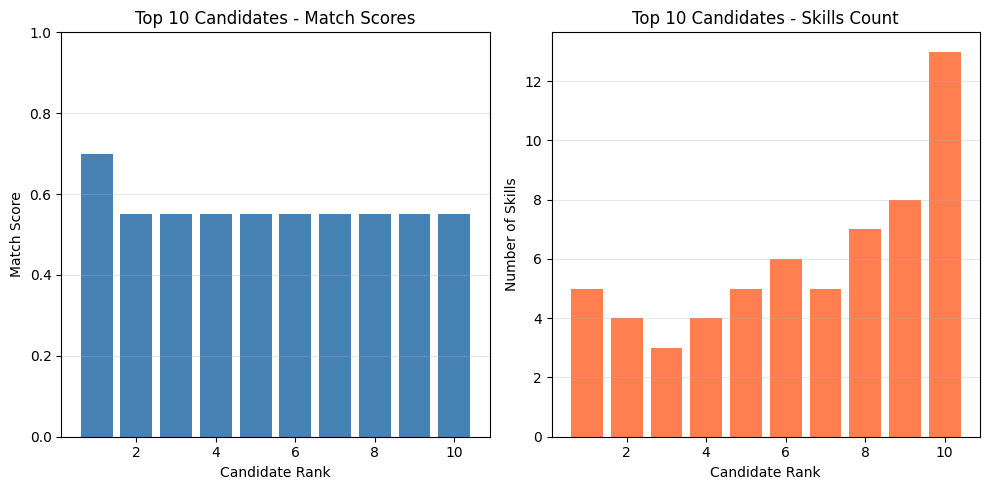


✅ Deliverable 2 Complete!
Agent successfully implemented with A* search algorithm.


In [9]:
# Performance metrics
print("📊 PERFORMANCE ANALYSIS")
print("="*60)
print(f"Dataset Size: {len(candidates)} candidates")
print(f"Search Algorithm: A* (A-star)")
print(f"Time Complexity: O(N log N)")
print(f"Space Complexity: O(N)")
print(f"Actual Search Time: {search_time:.4f} seconds")
print(f"Candidates per Second: {len(candidates)/search_time:.2f}")
print("="*60)

# Show match score distribution

scores = [r['match_score'] for r in results]
ranks = [r['rank'] for r in results]

plt.figure(figsize=(10, 5))

# Plot 1: Match scores
plt.subplot(1, 2, 1)
plt.bar(ranks, scores, color='steelblue')
plt.xlabel('Candidate Rank')
plt.ylabel('Match Score')
plt.title('Top 10 Candidates - Match Scores')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Plot 2: Skills distribution
skills_count = [r['num_skills'] for r in results]
plt.subplot(1, 2, 2)
plt.bar(ranks, skills_count, color='coral')
plt.xlabel('Candidate Rank')
plt.ylabel('Number of Skills')
plt.title('Top 10 Candidates - Skills Count')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Deliverable 2 Complete!")
print("Agent successfully implemented with A* search algorithm.")